In [2]:
import cv2
import os
import imutils
import numpy as np

import json
import random
from time import sleep

In [3]:
from IPython.display import clear_output
from google.colab.patches import cv2_imshow 
import matplotlib.pyplot as plt

In [4]:
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [5]:
%matplotlib inline

In [6]:
base_colab = 'drive/MyDrive/'

In [7]:
#@title
DATA_CONFIG = {
    "truly_generate": {
        "ubiris_url" : 'drive/MyDrive/ubirisv2/CLASSES_400_300_Part1/',
        "dataset_url": "drive/MyDrive/dataset/truly/",
        "total_people": 260,
        "allowed_img_ids": [13],
        "allowed_session_ids": [1],
        "excluded_pepople": [53,54,55,56]
    },
    "falsely_generate": {
        "ubiris_url" : 'drive/MyDrive/ubirisv2/CLASSES_400_300_Part1/',
        "dataset_url": "drive/MyDrive/dataset/falsely/",
        "total_people": 260,
        "allowed_img_ids": [13],
        "allowed_session_ids": [1],
        "excluded_pepople": [53,54,55,56]
    }
}

In [8]:
#@title
colab_path = 'drive/MyDrive/ubirisv2/CLASSES_400_300_Part1/'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title
def canny_edge_detect(image, min = 60, max=120):
  #Detecção de bordas por Canny
  _image = apply_blur_on_image(image)
  canny=cv2.Canny(_image, min, max)
  #canny=cv2.Canny(gray, 170, 200)
  #plt.imshow(canny,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
  return canny

In [ ]:
#@title
def apply_contourns(image, canny):
  edges, _ = cv2.findContours(canny.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  draw = cv2.drawContours(image.copy(), edges, -1, (255,255,255), 2)
  #plt.imshow(draw,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
  return draw

In [ ]:
#@title
def create_euclidean_array(circles,x_center,y_center):
  distances = []
  #print("Image center: {}".format((x_center,y_center)))
  for circle in circles:
    #x,y = circle[0],circle[1]
    point1 = np.array((circle[0],circle[1]))
    point2 = np.array((x_center,y_center))
    
    distances.append(np.linalg.norm(point1-point2))
  return distances

In [ ]:
#@title
def select_circle(circles,x_center,y_center,neighbors=3):
  _distances = []
  distances = []
  #print("Image center: {}".format((x_center,y_center)))
  _distances = create_euclidean_array(circles,x_center,y_center)
  
  indices = sorted(
    range(len(_distances)),
    key=lambda index: _distances[index]
  )
  #print("best distances static center: {} {} {}".format(_distances[indices[0]], _distances[indices[1]],_distances[indices[2]] ))
  selected_circles = []
  x, y = 0 , 0
  max_circles = neighbors if len(circles) > neighbors else len(circles)
  for i in range(max_circles):
    selected_circles.append(circles[indices[i]])
    x += circles[i][0]
    y += circles[i][1]
  factor = 1 #random.uniform(0, 0.5)
  x_adjusted = int((x/max_circles - x_center) * factor + x_center)
  y_adjusted = int((y/max_circles - y_center)  + y_center)
  #print("Image center adjusted: {}".format((x,y)))
  

  distances = create_euclidean_array(circles, x_adjusted, y_adjusted)

  #print("fixed {} - adjusted {}".format(min(_distances),min(distances)))
  if (min(_distances) > min(distances)):
    mindist = min(distances)
    minpos = distances.index(mindist)
  else:
    mindist = min(_distances)
    minpos = _distances.index(mindist)
  mindist = min(distances)
  minpos = distances.index(mindist)
  return (circles[minpos], mindist)

In [ ]:
def find_best_circle(draw, print_output=False, output_image= None, show_circles=False):
  _draw = draw.copy()
  houg_settings=[[70,80],[80,90]]
  #houg_settings=[[85,100]]
  (x, y, _) = draw.shape

  center_mask = np.zeros((x,y),np.uint8)
  cv2.circle(center_mask, (int(y/2), int(x/2)), int(y/2), (255, 255, 225), -1)
  _draw = apply_mask(center_mask,_draw)

  gray = cv2.cvtColor(_draw, cv2.COLOR_BGR2GRAY)


  gray_img_blur = cv2.medianBlur(gray, 5)
  
  '''

  kernel = np.ones((5,5),np.uint8)
  
  #Morphological Transformations
  
  gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_OPEN, kernel)
  print_image(gray_img_blur)
  gray_img_blur = cv2.erode(gray_img_blur,kernel,iterations  = 1)
  print_image(gray_img_blur)
  gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_OPEN, kernel)
  print_image(gray_img_blur)
  gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_GRADIENT, kernel)
  '''
  #gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_GRADIENT, kernel)
  #gray_img_blur = cv2.erode(gray_img_blur,kernel,iterations  = 1)
  #gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_TOPHAT, kernel)
  #gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_CLOSE, kernel)
  #gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_OPEN, kernel)

  #cimg = cv2.cvtColor(gray_img_blur, cv2.COLOR_GRAY2BGR)
  best_circle = None
  best_dist = None
  best_ray = None
  
  print_image(gray_img_blur)
  best_settings = None
  for settings in houg_settings:
    print("current houg settings: {}".format(settings))
    circles = cv2.HoughCircles(gray_img_blur, cv2.HOUGH_GRADIENT, 1, gray.shape[0]/64, param1=50, param2=13, minRadius=settings[0], maxRadius=settings[1])
    
    if show_circles and circles is not None and output_image is not None:
      circles = np.uint16(np.around(circles))
      img_circles = output_image.copy()
      for i in circles[0, :]:
          # Draw outer circle
          cv2.circle(img_circles, (i[0], i[1]), i[2], (0, 255, 0), 2)
          # Draw inner circle
          cv2.circle(img_circles, (i[0], i[1]), 2, (0, 0, 255), 3)
      print_image(img_circles)
      del(img_circles)
    
    circle, dist = None, None
    #if circles is not None and len(circles[0]) > 1 :
    if circles is not None:
      print("have circles")
      circle, dist = select_circle(circles[0], int(y/2) ,int(x/2))
      if circle is not None:
        best_circle = circle
        best_dist = dist
        best_ray = circle[2]
      if best_circle is None:
        best_circle = circle
        best_dist = dist
        best_ray = circle[2]
    


    if circle is not None:
      if dist < best_dist: #and best_ray < circle[2]:
      #if dist < best_dist and best_ray < circle[2]:
        best_settings = settings
        best_dist = dist
        best_circle = circle
        best_ray = circle[2]

  if best_circle is None:
    print("Not circles found")
    return None

  best_circle = np.uint16(np.around(best_circle))
  print("houg settings: {} with ray: {}".format(best_settings, best_circle[2]))
  print("best cicle found: ({},{})".format(best_circle[0], best_circle[1]))

  mask = np.zeros((x,y),np.uint8)
  cv2.circle(mask, (best_circle[0], best_circle[1]), best_circle[2], (255, 255, 225), -1)
  if output_image is not None:
    border_iris = output_image.copy()
    cv2.circle(border_iris, (best_circle[0], best_circle[1]), best_circle[2], (255, 255, 225), 2)
    cv2.circle(border_iris, (best_circle[0], best_circle[1]), 2, (0, 0, 255), 3)
    #plt.imshow(border_iris,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
    #plt.show()
    print_image(border_iris)
  return mask

In [ ]:
#@title
def apply_mask(mask,image):
  masked = cv2.bitwise_and(image, image, mask=mask)
  return masked

In [ ]:
#@title
def detect_best_circle_in(image,canny_config=(60,80),show_circles=False):
  #_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  _image = image.copy()
  #_canny = canny_edge_detect(image, 60, 120)
  _canny = canny_edge_detect(image, canny_config[0],canny_config[1])
  print_image(_canny)
  _image = apply_contourns(_image, _canny)
  mask = find_best_circle(_image, output_image = image.copy(),print_output=True,show_circles=show_circles)
  if mask is None:
    return image
  iris_rounded = apply_mask(mask,image.copy())
  print_image(iris_rounded)
  return iris_rounded
  

In [ ]:
#@title
def save_image(directory,filename,image):
  print(directory + filename)
  if not os.path.exists(directory):
    os.makedirs(directory)
  cv2.imwrite(str(directory + filename), image)

In [ ]:
#@title
def apply_blur_on_image(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray_img_blur = cv2.medianBlur(gray, 5)

  kernel = np.ones((5,5),np.uint8)
  
  #Morphological Transformations

  gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_OPEN, kernel)
  gray_img_blur = cv2.erode(gray_img_blur,kernel,iterations  = 1)
  gray_img_blur = cv2.morphologyEx(gray_img_blur, cv2.MORPH_OPEN, kernel)
  return gray_img_blur


In [ ]:
#@title
def print_image(image):
  plt.imshow(image,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
  plt.show()

In [ ]:
#@title
f = open(base_colab+'sessions.json')
sessions = json.load(f)
print(sessions)

In [ ]:
#@title
for session in sessions:
  print(sessions[session]["ok"])

In [ ]:
#@title
def create_dataset():
  removed_customers = [247, 449]
  failed_hough = [253,255,261,298]
  starts_in = 1
  total_eyes = 0
  rejected_eyes = 0
  for session in sessions:
    total_eyes += sessions[session]["ok"]
    for customer in sessions[session]["ok_ids"]:
      if customer < starts_in:
        continue

      if customer in removed_customers:
        continue
      files = ['C{}_S1_I13.tiff'.format(customer), 'C{}_S2_I13.tiff'.format(customer)]
      path = DATA_CONFIG["truly_generate"]["dataset_url"] + "C{}/".format(customer)

      for picture in files:
        if os.path.exists(path):
          existent_files = os.listdir(path)
          if picture in existent_files:
            continue

        print("Customer {}".format(customer))
        image_path = r"{}{}{}".format(base_colab, sessions[session]['path'], picture)
        image_path = image_path.replace("\\","/")
        print(image_path)
        original=cv2.imread(image_path)
        original=cv2.cvtColor(original, cv2.COLOR_RGB2BGR)

        iris= detect_best_circle_in(original, canny_config=(10,15))
        
        #plt.imshow(iris,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
        #plt.show()
        
        choice = str(input("salvar ? y/n"))
        save = True if choice == "y" else False

        if save:
          save_image(path, picture,cv2.cvtColor(iris, cv2.COLOR_BGR2RGB))
        else:
          rejected_eyes += 1
        clear_output()
      
  print("Completed {:.2f}% restant: {}".format(100*(total_eyes - rejected_eyes)/total_eyes, rejected_eyes ))


In [ ]:
#@title
"C1C220"[1:].split("C")

In [ ]:
#@title
os.listdir("{}".format(DATA_CONFIG["falsely_generate"]["dataset_url"]))  

In [ ]:
#@title
target = 3
for comb in ["C1C2","C3C4","C5C1","C7C4"]:
  ids = comb[1:].split("C")
  print(ids)
  if str(target) == ids[0]:
    print([int(ids[0]), int(ids[1])])
    print("achei")
    break


In [ ]:
#@title
def verify_data_integrity(label_path):
  if label_path == "falsely":
    combinations = os.listdir(DATA_CONFIG["falsely_generate"]["dataset_url"])
    issues = []
    print(len(combinations))
    for combination in combinations:
      target = combination[1:].split("C")
      for comb in combinations:
        ids = combination[1:].split("C")
        #print("{} {} {} {}".format(target[0] , ids[0] , target[1],ids[1]))
        if target[0] == ids[1] and target[1] == ids[0]:
          issues.append(combination)
    print(issues)
    issues = []
    
    for combination in combinations:
      files = os.listdir(DATA_CONFIG["falsely_generate"]["dataset_url"] + "{}".format(combination))
      if len(files) < 2:
        print(files)
        issues.append(combination)
    print(issues)

In [1]:
verify_data_integrity("falsely")

NameError: ignored

In [ ]:
def create_falsely_dataset():
  removed_customers = [53,54,407,408,409,410]
  starts_in = 1
  total_eyes = 0
  rejected_eyes = 0
  total_eyes += sessions["path1"]["bad"] + sessions["path2"]["bad"]
  for session in sessions:
    for customer in sessions[session]["bad_ids"]:
      if customer < starts_in:
        continue
      if customer in removed_customers:
        continue
      combination = []
      combinations = os.listdir(DATA_CONFIG["falsely_generate"]["dataset_url"])
      #print("searching folder with {} customer".format(customer))
      for comb in combinations:
        ids = comb[1:].split("C")
        if str(customer) == ids[0]:
          #print("folder with customer {} found".format(customer))
          combination = [int(ids[0]), int(ids[1])]
          break

      if combination == []:
        idx_customer2 = random.randrange(len(sessions[session]["bad_ids"]))
        customer2 = sessions[session]["bad_ids"][idx_customer2]
        if customer == customer2:
          idx_customer2 = random.randrange(len(sessions[session]["bad_ids"]))
          customer2 = sessions[session]["bad_ids"][idx_customer2]
        
        combination = [customer, customer2]


      files = []
      for person_id in combination:
        pictures = ['C{}_S1_I13.tiff'.format(person_id), 'C{}_S2_I13.tiff'.format(person_id)]
        for picture in pictures:
          image_path = r"{}{}{}".format(base_colab, sessions[session]['path'], picture)
          image_path = image_path.replace("\\","/")
          if os.path.exists(image_path):
            files.append(picture)
            break
          else:
            continue

      print("combination C{}-C{}".format(combination[0],combination[1]))
      if len(files) < 2:
        print(files)
        print("Not enough pictures")
        continue


      path = DATA_CONFIG["falsely_generate"]["dataset_url"] + "C{}C{}/".format(combination[0],combination[1])

      for picture in files:
        clear_output()
        if os.path.exists(path):
          existent_files = os.listdir(path)
          if picture in existent_files:
            continue

        image_path = r"{}{}{}".format(base_colab, sessions[session]['path'], picture)
        image_path = image_path.replace("\\","/")
        print(image_path)
        original=cv2.imread(image_path)
        original=cv2.cvtColor(original, cv2.COLOR_RGB2BGR)

        iris= detect_best_circle_in(original, canny_config=(44,50),show_circles=True)
        
        #plt.imshow(iris,cmap=plt.cm.gray), plt.xticks([]), plt.yticks([])
        #plt.show()
        
        print("combination C{}-C{} pic: {}".format(combination[0],combination[1],picture))
        choice = str(input("salvar ? y/n"))
        save = True if choice == "y" else False

        if save:
          save_image(path, picture,cv2.cvtColor(iris, cv2.COLOR_BGR2RGB))
        else:
          rejected_eyes += 1
        #clear_output()
      
  print("Completed {:.2f}% restant: {}".format(100*(total_eyes - rejected_eyes)/total_eyes, rejected_eyes ))

In [ ]:
create_falsely_dataset()

Completed 100.00% restant: 0


In [ ]:
#@title

img = cv2.imread("drive/MyDrive/ubirisv2/CLASSES_400_300_Part1/C256_S1_I13.tiff")
a = apply_blur_on_image(img)
print_image(a)

In [ ]:
#@title
img = cv2.imread("drive/MyDrive/ubirisv2/CLASSES_400_300_Part1/C256_S1_I13.tiff")
print_image(img)
im = detect_best_circle_in(img, canny_config=(10,20))
print_image(im)

In [ ]:
#@title
create_dataset()

In [ ]:
#@title
img = cv2.imread("drive/MyDrive/ubirisv2/CLASSES_400_300_Part2/C430_S1_I13.tiff")
imgv2_2_work=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
detect_best_circle_in(imgv2_2_work)

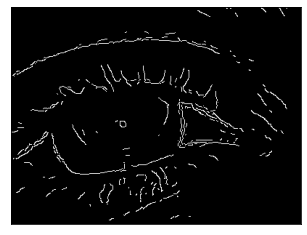

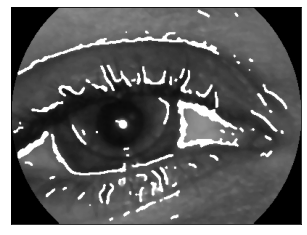

current houg settings: [70, 80]


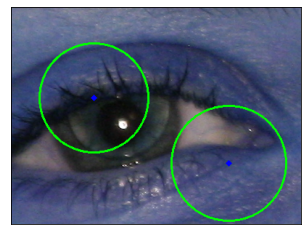

have circles
current houg settings: [80, 90]


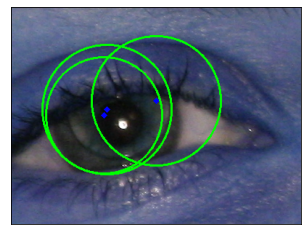

have circles
houg settings: None with ray: 89
best cicle found: (132,142)


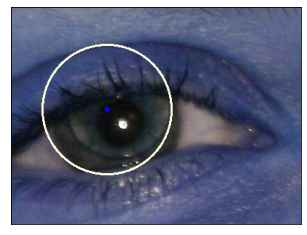

target image above


In [ ]:
img = cv2.imread("drive/MyDrive/ubirisv2/CLASSES_400_300_Part2/C475_S1_I13.tiff")
img_2_work=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
canny = canny_edge_detect(img_2_work, 44,50)
print_image(canny)
img_2_work = apply_contourns(img_2_work, canny)
mask = find_best_circle(img_2_work, output_image = img.copy(),print_output=True, show_circles=True)
iris_rounded = apply_mask(mask,img_2_work.copy())
print("target image above")
#print_image(iris_rounded)